In [1]:
import numpy as np

from math import pi, sin, cos, sqrt, tanh

from siltsong import spherical_to_cartesian, plot_density_powernorm, radiative_transfer
from siltsong.dust import mrn, thermal_emission, henyey_greenstein
from siltsong.stars import blackbody

In [2]:
view_length = 32000
distance_steps = 200
theta_steps = 360
phi_steps = 360
distance_substeps = 10

resolution = 201
depth = 201
depth_substeps = 10
dw = view_length / depth
ds_depth = dw / depth_substeps
grid_size = view_length / resolution

inclination_degrees = 60
inclination = pi * (inclination_degrees / 180)
sin_inc = sin(inclination)
cos_inc = cos(inclination)

ms_count = 1e5

wavelength = 2.5e-4 # NIRcam

rho0_disk = 0.1
Rd = 2500 
zd = 300
rb = 500
rho0_bulge = 0.05

rho0_gas = 1.0
Rg = 4000
zg = 150

In [3]:
central_source = 0 # blackbody(wavelength, temperature = 1e8)
    
sca_cm_squared_per_g_stars, ext_cm_squared_per_g_stars = 0, 1.6e-15 # Assuming stars don't scatter light, so many suns in pc^2

sca_cm_squared_per_g_gas, ext_cm_squared_per_g_gas = 3e-4 / ((3.24 * 10 ** 19) ** 2), 0 # HI, Rayleigh scattering, but gas has no cross section and no continuum emission

sca_cm_squared_per_g_dust, ext_cm_squared_per_g_dust = mrn(wavelength = wavelength)[0] / ((3.24 * 10 ** 19) ** 2), mrn(wavelength = wavelength)[1] / ((3.24 * 10 ** 19) ** 2)

source_function_stars = (3.24 * 10 ** 19) ** 2 * blackbody(wavelength, temperature = 6000) # this outputs in cgs so I have to convert it to per pc^2

source_function_gas = (3.24 * 10 ** 19) ** 2 * blackbody(wavelength, temperature = 6000) # WNM, maybe

source_function_dust = (3.24 * 10 ** 19) ** 2 * blackbody(wavelength, temperature = 20) # this outputs in cgs so I have to convert it to per pc^2

def scattering_phase_function_stars(angle):
    return 0

def scattering_phase_function_gas(angle):
    return 1 / (4 * pi)

def scattering_phase_function_dust(angle):
    return henyey_greenstein(angle, asymmetry_constant = 0.6)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/siltsong/dust.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  extinction_efficiency_integral = quad(lambda a: a ** (2 + exponent) * Q_ext_lambda(2 * pi * a / wavelength), grain_size_min, grain_size_max)[0] # integral after P in formual A9 of Li et al. 2024


In [4]:
def density_cartesian_stars(x, y, z):
    
    R = np.sqrt(x ** 2 + y ** 2)
    disk_density = rho0_disk * np.exp(-R / Rd) * np.exp(-np.abs(z) / zd)
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    bulge_density = rho0_bulge / (1 + (r / rb) ** 2) ** (2.5)

    return disk_density + bulge_density

def density_spherical_stars(r, theta):
    x, y, z = spherical_to_cartesian(r, theta, 0)
    return density_cartesian_stars(x, y, z)

def density_cartesian_gas(x, y, z):

    R = np.sqrt(x ** 2 + y ** 2)
    return rho0_gas * np.exp(-R / Rg) * (1 / np.cosh(z / zg)) ** 2

def density_spherical_gas(r, theta):
    x, y, z = spherical_to_cartesian(r, theta, 0)
    return density_cartesian_gas(x, y, z)

def density_cartesian_dust(x, y, z):
    return 0.0005 * density_cartesian_gas(x, y, z)

def density_spherical_dust(r, theta):
    return 0.0005 * density_spherical_gas(r, theta)

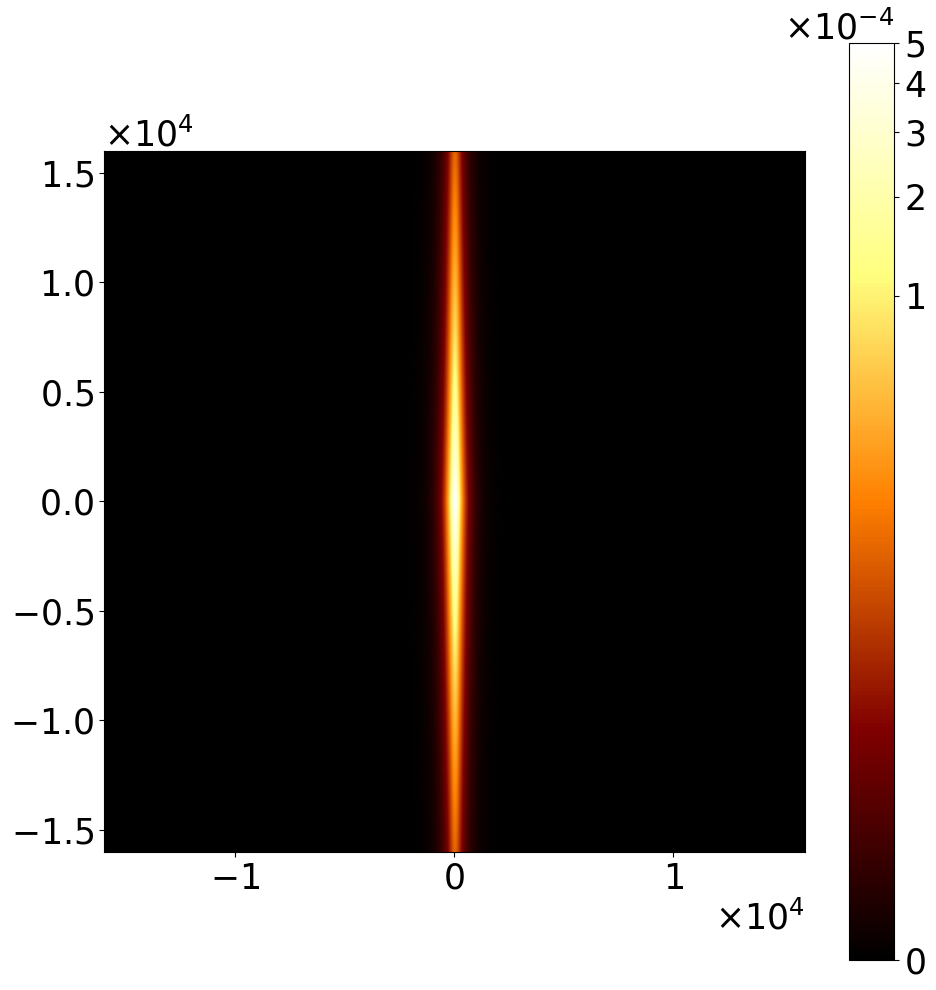

In [5]:
plot_density_powernorm(density_cartesian_dust, view_length, power = 0.2, units = 'None') # sorry the distance and density units...

In [6]:
spherical_densities = [density_spherical_stars, density_spherical_gas, density_spherical_dust]
cartesian_densities = [density_cartesian_stars, density_cartesian_gas, density_cartesian_dust]
sca_list = [sca_cm_squared_per_g_stars, sca_cm_squared_per_g_gas, sca_cm_squared_per_g_dust]
ext_list = [ext_cm_squared_per_g_stars, ext_cm_squared_per_g_gas, ext_cm_squared_per_g_dust]
source_function_list = [source_function_stars, source_function_gas, source_function_dust]
scattering_phase_function_list = [scattering_phase_function_stars, scattering_phase_function_gas, scattering_phase_function_dust]

In [7]:
image = radiative_transfer(view_length, inclination_degrees, resolution, 
                           central_source, 
                           spherical_densities, cartesian_densities, 
                           sca_list, ext_list, source_function_list, scattering_phase_function_list, 
                           depth, depth_substeps, distance_steps, distance_substeps, theta_steps, phi_steps, 
                           ms_count, axisymmetry = True, reflection_symmetry = True)

Sending photons from the central source(s). 
Tracing single scattered photons: 


 90%|████████████████████████████████████▉    | 324/360 [04:59<00:33,  1.08it/s]Exception ignored in: <function ResourceTracker.__del__ at 0x1093353a0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1025953a0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _

Tracing multiple scattered photons: 


100%|███████████████████████████████████| 100000/100000 [45:03<00:00, 36.99it/s]


Performing peel-off: 


100%|█████████████████████████████████████████| 201/201 [03:07<00:00,  1.07it/s]


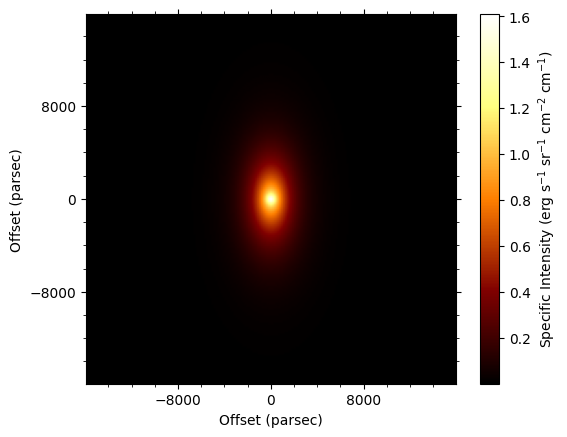

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

pixel_size = view_length / resolution
n_pixels = image.shape[0]
half_size = (n_pixels // 2) * pixel_size
extent = [-half_size, half_size, -half_size, half_size]

plt.imshow(image / ((3.24 * 10 ** 19) ** 2), origin = 'lower', cmap = 'afmhot', extent = extent)

ax = plt.gca()
ax.set_aspect('equal')
ax.xaxis.set_major_locator(MultipleLocator(view_length // 4))
ax.xaxis.set_minor_locator(MultipleLocator(view_length // 16))
ax.yaxis.set_major_locator(MultipleLocator(view_length // 4))
ax.yaxis.set_minor_locator(MultipleLocator(view_length // 16))
ax.tick_params(which = 'both', direction = 'out', top = True, right = True)

ax.set_xlabel('Offset (parsec)')
ax.set_ylabel('Offset (parsec)')

cbar = plt.colorbar()
cbar.set_label(r'Specific Intensity (erg s$^{{-1}}$ sr$^{{-1}}$ cm$^{{-2}}$ cm$^{{-1}}$)')

plt.show()

In [9]:
# END